In [1]:
from keras.models import Sequential
from keras.layers import LSTM
import numpy as np

Using TensorFlow backend.


In [12]:
# 入力系列は長さ3だが、出力の系列は1（最後の入力に対してだけ出力する）
model = Sequential()
model.add(LSTM(5, input_shape=(3, 1)))
model.compile(optimizer='adam', loss='mse')

# input time steps
data = np.array([0.1, 0.2, 0.3]).reshape((1, 3, 1))
res = model.predict(data)
print(res)
print(res.shape)

[[-0.01279215 -0.02360711 -0.05856827 -0.01319192  0.03173996]]
(1, 5)


In [13]:
# LSTMをstackするには入力系列のそれぞれに対して出力する必要がある
# return_sequences=TrueとすればOK
model = Sequential()
model.add(LSTM(5, return_sequences=True, input_shape=(3, 1)))
model.compile(optimizer='adam', loss='mse')

data = np.array([0.1, 0.2, 0.3]).reshape((1, 3, 1))
res = model.predict(data)
print(res)
print(res.shape)

[[[-0.00477986 -0.00021732 -0.01271267  0.00416994 -0.00267648]
  [-0.01305808  0.00077787 -0.03372005  0.01082444 -0.0079989 ]
  [-0.02405662  0.00373452 -0.06012451  0.01877143 -0.01577036]]]
(1, 3, 5)


## Sine Wave

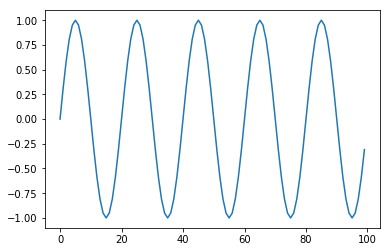

In [16]:
from math import sin
from math import pi
import matplotlib.pyplot as plt
%matplotlib inline

length = 100
freq = 5
sequence = [sin(2 * pi * freq * (i / length)) for i in range(length)]

plt.plot(sequence)

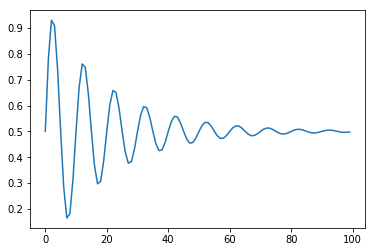

In [17]:
from math import sin, pi, exp
import matplotlib.pyplot as plt

length = 100
period = 10
decay = 0.05
sequence = [0.5 + 0.5 * sin(2 * pi * i / period) * exp(-decay * i) for i in range(length)]

plt.plot(sequence)

In [18]:
# generate damped sine wave in [0, 1]
def generate_sequence(length, period, decay):
    return [0.5 + 0.5 * sin(2 * pi * i / period) * exp(-decay * i) for i in range(length)]

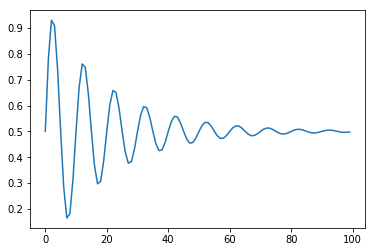

In [19]:
seq = generate_sequence(100, 10, 0.05)
plt.plot(seq)

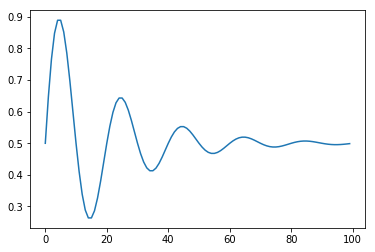

In [21]:
seq = generate_sequence(100, 20, 0.05)
plt.plot(seq)

In [24]:
# generate input and output pairs of damped sine waves
import numpy as np
import random

def generate_examples(length, n_patterns, output):
    X, y = list(), list()
    for _ in range(n_patterns):
        p = random.randint(10, 20)  # period
        d = random.uniform(0.01, 0.1)  # decay
        sequence = generate_sequence(length + output, p, d)
        X.append(sequence[:-output])
        y.append(sequence[-output:])
    X = np.array(X).reshape(n_patterns, length, 1)  # (samples, time steps, features)の3Dテンソル
    y = np.array(y).reshape(n_patterns, output)
    return X, y

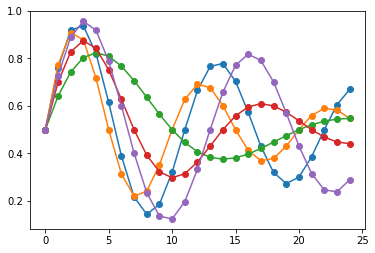

In [31]:
X, y = generate_examples(20, 5, 5)
for i in range(len(X)):
    plt.plot([x for x in X[i, :, 0]] + [x for x in y[i]], 'o-')

In [32]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

length = 50
output = 5  # 最後の5ステップの値を予測する

model = Sequential()
model.add(LSTM(20, return_sequences=True, input_shape=(length, 1)))
model.add(LSTM(20))
model.add(Dense(output))
model.compile(loss='mae', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 50, 20)            1760      
_________________________________________________________________
lstm_14 (LSTM)               (None, 20)                3280      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 105       
Total params: 5,145
Trainable params: 5,145
Non-trainable params: 0
_________________________________________________________________


- https://stackoverflow.com/questions/43882796/when-does-keras-reset-an-lstm-state
- デフォルトではstateful = False
- バッチごとにパラメータ更新時に内部状態が自動的にリセットされる
- バッチ内の各シーケンス（サンプル）ごとに内部状態を *別々に* 管理

In [34]:
# fit model
X, y = generate_examples(length, 10000, output)
history = model.fit(X, y, batch_size=10, epochs=1)

Epoch 1/1
10000/10000 [==============================] - 313s - loss: 0.0363   


In [38]:
# evaluate model
X, y = generate_examples(length, 1000, output)
loss = model.evaluate(X, y, verbose=0)
print('MAE: %f' % loss)

MAE: 0.023665


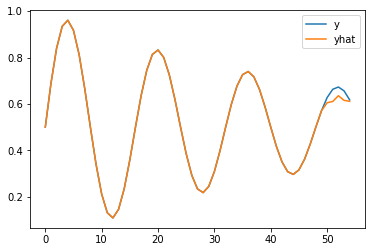

In [79]:
# prediction on new data
X, y = generate_examples(length, 1, output)
yhat = model.predict(X, verbose=0)
X = X.reshape(50)
y = y.reshape(5)
yhat = yhat.reshape(5)
plt.plot(np.concatenate((X, y)), label='y')
plt.plot(np.concatenate((X, yhat)), label='yhat')
plt.legend()

## Vanilla LSTMの場合

In [97]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

length = 50
output = 5  # 最後の5ステップの値を予測する

model = Sequential()
model.add(LSTM(20, input_shape=(length, 1)))
model.add(Dense(output))
model.compile(loss='mae', optimizer='adam')
model.summary()

# fit model
X, y = generate_examples(length, 10000, output)
history = model.fit(X, y, batch_size=10, epochs=1)

# evaluate model
X, y = generate_examples(length, 1000, output)
loss = model.evaluate(X, y, verbose=0)
print('MAE: %f' % loss)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 20)                1760      
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 105       
Total params: 1,865
Trainable params: 1,865
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1
10000/10000 [==============================] - 170s - loss: 0.0495   
MAE: 0.021882


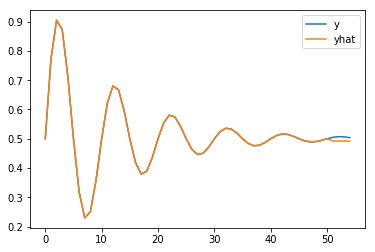

In [105]:
# prediction on new data
X, y = generate_examples(length, 1, output)
yhat = model.predict(X, verbose=0)
X = X.reshape(50)
y = y.reshape(5)
yhat = yhat.reshape(5)
plt.plot(np.concatenate((X, y)), label='y')
plt.plot(np.concatenate((X, yhat)), label='yhat')
plt.legend()